In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%load_ext autoreload
%autoreload 2
plt.style.use('ggplot')
import sys 
import os
sys.path.append('/'.join(os.getcwd().split('/')[:4]))
from config.get import cfg
from tensorflow import keras
from tensorflow.keras import layers
import autoencoders

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loaidng data

In [35]:
X_train = np.load(cfg['files']["raw_train_features"])
X_test  = np.load(cfg['files']["raw_test_features"])
print(f"shapes : X_train={X_train.shape},X_test={X_test.shape}")

shapes : X_train=(4856, 3, 600, 2),X_test=(1213, 3, 600, 2)


In [41]:

np.load(cfg['files']["train_ids"]).shape ,np.load(cfg['files']["test_ids"]).shape

((4856,), (1213,))

In [42]:
cfg

{'directories': {'data_dir': '/home/kapps/dex-cyclic-arbitrage/data/',
  'uniswap_raw_data': '/home/kapps/dex-cyclic-arbitrage/data/uniswap_raw_data/',
  'ML_features': '/home/kapps/dex-cyclic-arbitrage/data/ML_features/'},
 'fig_dir': {'clustering': '/home/kapps/dex-cyclic-arbitrage/figures/clustering/',
  'data_exploration': '/home/kapps/dex-cyclic-arbitrage/figures/data_exploration/',
  'embedding': '/home/kapps/dex-cyclic-arbitrage/figures/embedding/'},
 'files': {'cycles_in_Uniswap': '/home/kapps/dex-cyclic-arbitrage/data/cycles_in_Uniswap.json',
  'preprocessed_data': '/home/kapps/dex-cyclic-arbitrage/data/uniswap_data.csv',
  'raw_test_features': '/home/kapps/dex-cyclic-arbitrage/data/ML_features/raw_test_features.npy',
  'raw_train_features': '/home/kapps/dex-cyclic-arbitrage/data/ML_features/raw_train_features.npy',
  'test_ids': '/home/kapps/dex-cyclic-arbitrage/data/ML_features/test_ids.npy',
  'train_ids': '/home/kapps/dex-cyclic-arbitrage/data/ML_features/train_ids.npy',
 

# Loading model

In [36]:
def CNN_and_FC():
    model_name = "CNN_and_FC"
    # build encoder
    input_img = keras.Input(shape=(3,600, 2))
   
    x = layers.Conv2D(8, (3, 3), activation='elu', padding='same')(input_img)
    x = layers.MaxPooling2D((3, 3), padding='same')(x)
    x = layers.Conv2D(4, (3, 3), activation='elu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    encoded = layers.Conv2D(1, (2, 2), activation='elu', padding='same')(x)
    x = layers.Dense(np.array([1, 200, 1]),  activation='elu')(encoded)
    # build decoder
    x = layers.Conv2D(4, (2, 2), activation='elu', padding='same')(x)
    x = layers.UpSampling2D((1, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation='elu', padding='same')(x)
    x = layers.UpSampling2D((3, 3))(x)
    decoded = layers.Conv2D(2, (3, 3), activation='elu', padding='same')(x)
    # combine encoder and decoder
    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error',)
    return model_name, autoencoder

In [37]:
def fully_connected_5L():
    model_name = "fully_connected_5L"
    in_shape = (3,600, 2) 
    # build encoder
    input_layer = keras.Input(shape=in_shape)
    x = layers.Reshape([in_shape[0]*in_shape[1]*in_shape[2]])(input_layer)
    x = layers.Dense(1200,  activation='elu')(x)
    x = layers.Dense(600,  activation='elu')(x)
    x = layers.Dense(100,  activation='elu')(x)
    x = layers.Dense(600,  activation='elu')(x)
    x = layers.Dense(1200,  activation='elu')(x)
    x = layers.Dense(in_shape[0]*in_shape[1]*in_shape[2],  activation='elu')(x)
    output_layer =layers.Reshape(in_shape)(x)
    
    
    # combine encoder and decoder
    autoencoder = keras.Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error',)
    return model_name ,autoencoder
def fully_connected_5L():
    model_name = "fully_connected_5L"
    in_shape = (3,600, 2) 
    # build encoder
    input_layer = keras.Input(shape=in_shape)
    x = layers.Reshape([in_shape[0]*in_shape[1]*in_shape[2]])(input_layer)
    x = layers.Dense(1200,  activation='elu')(x)
    x = layers.Dense(600,  activation='elu')(x)
    x = layers.Dense(100,  activation='elu')(x)
    x = layers.Dense(600,  activation='elu')(x)
    x = layers.Dense(1200,  activation='elu')(x)
    x = layers.Dense(in_shape[0]*in_shape[1]*in_shape[2],  activation='elu')(x)
    output_layer =layers.Reshape(in_shape)(x)
    
    
    # combine encoder and decoder
    autoencoder = keras.Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error',)
    return model_name ,autoencoder

In [38]:

model_name,autoencoder = fully_connected_5L()
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3, 600, 2)]       0         
                                                                 
 reshape_8 (Reshape)         (None, 3600)              0         
                                                                 
 dense_18 (Dense)            (None, 1200)              4321200   
                                                                 
 dense_19 (Dense)            (None, 600)               720600    
                                                                 
 dense_20 (Dense)            (None, 100)               60100     
                                                                 
 dense_21 (Dense)            (None, 600)               60600     
                                                                 
 dense_22 (Dense)            (None, 1200)              7212

In [39]:
hist = autoencoder.fit(X_train, X_train,epochs=80)

Epoch 1/80
152/152 [==============================] - 32s 209ms/step - loss: 0.2871
Epoch 2/80
152/152 [==============================] - 31s 206ms/step - loss: 0.1776
Epoch 3/80
152/152 [==============================] - 32s 209ms/step - loss: 0.1558
Epoch 4/80
152/152 [==============================] - 30s 195ms/step - loss: 0.1395
Epoch 5/80
152/152 [==============================] - 32s 208ms/step - loss: 0.1280
Epoch 6/80
152/152 [==============================] - 32s 209ms/step - loss: 0.1220
Epoch 7/80
152/152 [==============================] - 32s 211ms/step - loss: 0.1178
Epoch 8/80
152/152 [==============================] - 32s 207ms/step - loss: 0.1135
Epoch 9/80
152/152 [==============================] - 31s 205ms/step - loss: 0.1090
Epoch 10/80
152/152 [==============================] - 32s 208ms/step - loss: 0.1053
Epoch 11/80
152/152 [==============================] - 32s 208ms/step - loss: 0.1034
Epoch 12/80
152/152 [==============================] - 31s 207ms/step - lo

KeyboardInterrupt: 

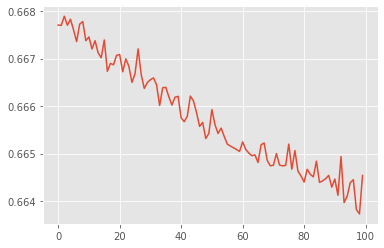

In [29]:
plt.plot(hist.history["loss"])
plt.show()

# Saving 

In [30]:
autoencoder.save(cfg["models"]["autoencoder"] + f"/{model_name}")

In [26]:
model_name

'CNN'

# testing 

In [31]:
def mean_squared_error(x,y):
    return np.sum((x-y)**2)/x.size

train_pred = autoencoder(X_train).numpy()
test_pred  = autoencoder(X_test).numpy()

print(f"MSE train : {mean_squared_error(train_pred,X_train)} \nMSE test  : {mean_squared_error(test_pred,X_test)}")

MSE train : 0.6656895960779817 
MSE test  : 0.672439797862461
